In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
from linear_mcmc import *

from redTools import *
from Kcorrect import *
from calibTools import *

In [2]:
# calib_maglim = [3974, 6699, 9962, 11139, 12460, 13163, 19871, 
#                 21102, 22277, 26761, 28378, 29128, 38148, 41020, 
#                 41093, 44982, 45084, 46127, 49448, 50073, 53641, 67908, 72228]
# I_maglim = [38803, 39181, 39431, 39619, 40005, 40107, 40147, 40588,
#             40604, 41567, 41829, 42768, 5807403, 5057729, 4002181, 4321374, 37814]


########### Updated list using the color-LogWimx correaltion
calib_maglim = [3974, 6699, 19871, 22277, 28378, 38148, 41020, 41093, 46127, 49448, 53641]
calib_maglim += [6699, 9962, 12460, 13163, 22277, 26761, 29128, 38148, 41020, 44982, 45084, 46127, 67908, 72228]

I_maglim = [38803,   39181,   39431,   39619,   40005,   40107,   40588,   40604,
   41567,   41829,   42768, 5807403, 5057729,   37814]
I_maglim += [38803, 39181, 39431, 40005, 40107, 40147, 41567, 42768, 14548, 14590]

In [3]:
table   = np.genfromtxt('corrected_mags_linewidth_all.csv' , delimiter='|', 
                        filling_values=-1, names=True, dtype=None, encoding=None)

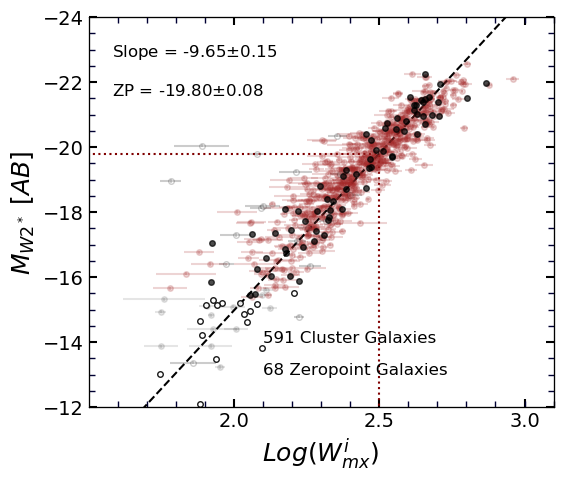

In [4]:
band = 'w2'

fig, ax, Clusters, S_ZP, zp_calibs = makeTF(table, pgcFaint=I_maglim, calib_maglim=calib_maglim, 
                                 band=band, makePlot=True, 
                                            addSouth=True,
                                            getZPcalib=True)

In [13]:
def CurveFUN(x, a, b, c):
    return a*x**2+b*x+c

def ZP_CurveF(mag, c):
    quadW = mag - c 
    return quadW  

Clusters, slope0, zp0, slope_e0 = TF_iter(table, band = band, n_iter=10, verbose=False, 
                                            addSouth=True, pgcFaint=I_maglim)
print slope0, zp0




for iterr in range(1):
    
    isFirst = True
    print
    for key in Clusters:

        myCluster = Clusters[key]
        zpCluster = myCluster['zp']

        pgc = myCluster['pgc']
        band = myCluster['band']   
        logWimx_  = myCluster['logWimx']
        logWimx_e_= myCluster['logWimx_e']
        mag_      = myCluster['mag']

        logWimx_w  = myCluster['logWimx_w']
        logWimx_e_w= myCluster['logWimx_e_w']
        mag_w   = myCluster['mag_w']    


        mag_err = logWimx_e_*slope0

        indx  = []
        indx_ = []
        for i, id in enumerate(pgc):
            if not id in I_maglim:
                indx.append(i)    
            else:
                indx_.append(i) 

        if isFirst:
            X  = logWimx_[indx]
            Xe = logWimx_e_[indx]
            Y  = mag_[indx]-zpCluster
            Ye = mag_err[indx]

            isFirst = False

            X_w  = logWimx_w
            Xe_w = logWimx_e_w
            Y_w  = mag_w-zpCluster          

            if len(indx_)>0:
                X_f  = logWimx_[indx_]
                Xe_f = logWimx_e_[indx_]
                Y_f  = mag_[indx_]-zpCluster            

        else:
            X  = np.concatenate((X, logWimx_[indx]))
            Xe = np.concatenate((Xe, logWimx_e_[indx]))
            Y  = np.concatenate((Y, mag_[indx]-zpCluster))
            Ye = np.concatenate((Ye, mag_err[indx]))

            X_w  = np.concatenate((X_w, logWimx_w))
            Xe_w = np.concatenate((Xe_w, logWimx_e_w))
            Y_w  = np.concatenate((Y_w, mag_w-zpCluster))        

            if len(indx_)>0:
                try:
                    X_f  = np.concatenate((X_f, logWimx_[indx_]))
                    Xe_f = np.concatenate((Xe_f, logWimx_e_[indx_]))
                    Y_f  = np.concatenate((Y_f, mag_[indx_]-zpCluster))   
                except:
                    X_f  = logWimx_[indx_]
                    Xe_f = logWimx_e_[indx_]
                    Y_f  = mag_[indx_]-zpCluster                  


#         if iterr>0: 

#                 W = logWimx_[indx]-2.5
#                 dW = logWimx_e_[indx]
#                 fit, cov = curve_fit(ZP_CurveF, mag_[indx]-zpCluster, A*W**2+B*W,
#                                      sigma=np.sqrt((2*A*W*dW)**2+(B*dW)**2))
#                 if myCluster['name'] in ['Virgo']:
#                     print myCluster['name'], '%.2f'%zpCluster, '%.2f'%fit[0]
#                 myCluster['zp'] += fit[0]

#     fit, cov = curve_fit(CurveFUN, X-2.5, Y, sigma=Ye)
#     A = fit[0]
#     B = fit[1]
#     C = fit[2]
#     print A, B, C
   

#     if iterr<4:
#         del X, Xe, Y, Ye
#         del X_w, Xe_w, Y_w
#         del X_f, Xe_f, Y_f
        
fit, cov = curve_fit(CurveFUN, X-2.5, Y, sigma=Ye)
A = fit[0]
B = fit[1]
C = fit[2]

print A, B, C

Ae = np.sqrt(cov[0][0])
Be = np.sqrt(cov[1][1])

-9.648985382071904 -0.002520613073782777

2.0538398651742003 -8.383223183253266 0.04722961784819814


Curve: 2.05 0.80
Slope: -8.38 0.15
ZP: -19.69 0.07
rms:  0.5874465349789693


Text(1.95,-12.6,'rms = 0.59 (mag)')

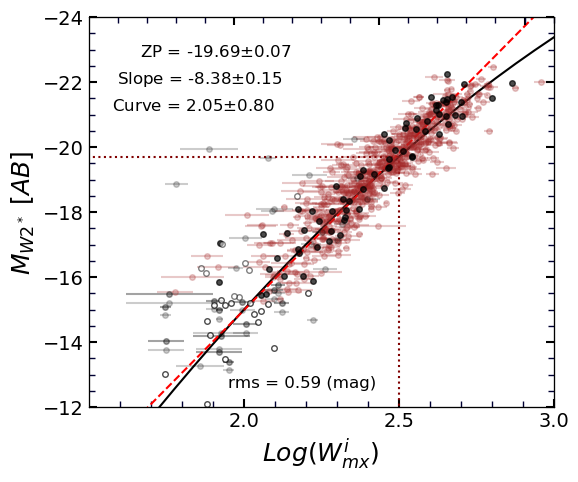

In [14]:

fig, ax = makeFig(band=band, xLim = (1.5,3.1), yLim = (-12,-24), MAGabs=True)






def ZP_CurveF(x, c):
    
#     return A*x**2+B*x+c  
    quadW = x - c 
    return quadW 






ax.set_ylim(-12,-24)
ax.set_xlim(1.5,3)
ax.set_xticks(np.arange(2, 3.5, step=0.5))





allZP = all_ZP(table, band=band, slope=slope0, pgcFaint=calib_maglim)
zp_linear =  allZP['zp']
pgc       = allZP['pgc']
logWimx   = allZP['logWimx']
logWimx_e = allZP['logWimx_e']
MAG       = allZP['MAG']
MAG_e     = allZP['mag_e']

X_zp_w  = allZP['logWimx_w']
Xe_zp_w = allZP['logWimx_e_w']
Y_zp_w  = allZP['MAG_w'] 



indx  = []
indx_ = []
for i, id in enumerate(pgc):
    if not id in calib_maglim:
        indx.append(i) 
    else:
        indx_.append(i) 
            
X_zp  = logWimx[indx]
Y_zp  = MAG[indx]
Xe_zp = logWimx_e[indx]
Ye_zp = MAG_e[indx]

X_zp_f  = logWimx[indx_]
Y_zp_f  = MAG[indx_]
Xe_zp_f = logWimx_e[indx_]

        
# 
x = np.linspace(0,3,50)

W = logWimx[indx]-2.5
dW = logWimx_e[indx]

MAG_err = np.sqrt((2*A*W*dW)**2+(B*dW)**2)


# fit, cov = curve_fit(ZP_CurveF, X_zp-2.5, Y_zp, sigma=MAG_err)
W = X_zp-2.5
dW = Xe_zp
fit, cov = curve_fit(ZP_CurveF, Y_zp, A*W**2+B*W, sigma=np.sqrt((2*A*W*dW)**2+(B*dW)**2))


zp_curve = fit[0]
zp_curve_e = np.sqrt(cov[0])


dye = {"u":"blue","g":"green","r":"red","i":"orange","z":"maroon","w1":"purple", 'w2': "brown"}



ax.errorbar(X, Y+zp_curve, xerr=Xe, fmt='o', alpha=0.25, ms=4, color=dye[band])
ax.errorbar(X_w, Y_w+zp_curve, xerr=Xe_w, fmt='o', ms=4, color='k', alpha=0.20)
ax.errorbar(X_f, Y_f+zp_curve, xerr=Xe_f, fmt='o', ms=4, color='k', alpha=0.20)
y = CurveFUN(x-2.5, A, B, zp_curve)
ax.plot(x,y, 'k-') 

ax.plot(x, slope0*(x-2.5)+zp_linear, 'r--')

ax.errorbar(X_zp, Y_zp, xerr=Xe_zp*0, fmt='ko', alpha=0.7, ms=4)
ax.errorbar(X_zp_f, Y_zp_f, xerr=Xe_zp_f*0, fmt='ko', alpha=0.7, ms=4, mfc='white')
ax.errorbar(X_zp_w, Y_zp_w, xerr=Xe_zp_w*0, fmt='ko', alpha=0.5, ms=4, mfc='white')



print "Curve:", '%.2f'%A, '%.2f'%Ae
print "Slope:", '%.2f'%B, '%.2f'%Be
print "ZP:", '%.2f'%zp_curve, '%.2f'%zp_curve_e


x0 = 2.5
y0 = 100
x1 = 2.5
y1 = CurveFUN(x1-2.5, A, B, zp_curve)
ax.plot([x0,x1],[y0,y1], ':', color='maroon') 


x2 = -5
y2 = y1
x3 = x1
y3 = y1
ax.plot([x2,x3],[y2,y3], ':', color='maroon') 

# x = np.linspace(1.6,2.4,20)
# ax.plot(x,-17-(1.18*(x-2.5)-0.47),'--', lw=1, color='navy')

Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.89*Xlm[0]+0.11*Xlm[1]
y0 = 0.1*Ylm[0]+0.9*Ylm[1]
ax.text(x0,y0, "ZP = "+"%.2f" % zp_curve+'$\pm$'+"%.2f" % zp_curve_e, fontsize=12, color='k')
x0 = 0.94*Xlm[0]+0.06*Xlm[1]
y0 = 0.17*Ylm[0]+0.83*Ylm[1]
ax.text(x0,y0, "Slope = "+"%.2f" % B+'$\pm$'+"%.2f" % Be, fontsize=12, color='k')
x0 = 0.95*Xlm[0]+0.05*Xlm[1]
y0 = 0.24*Ylm[0]+0.76*Ylm[1]
ax.text(x0,y0, "Curve = "+"%.2f" % A+'$\pm$'+"%.2f" % Ae, fontsize=12, color='k')


M = Y+zp_curve

M_TF_curve = CurveFUN(X-2.5, A, B, zp_curve)
    
delta = M_TF_curve-M

Y_fit2 = delta
std = np.sqrt(np.mean((Y_fit2)**2))
indx, = np.where(Y_fit2<3*std)
Y_fit1 = Y_fit2[indx]
indx, = np.where(Y_fit1>-3*std)
Y_fit2 = Y_fit1[indx]

std = np.sqrt(np.mean((Y_fit2)**2))
indx, = np.where(Y_fit2<3*std)
Y_fit1 = Y_fit2[indx]
indx, = np.where(Y_fit1>-3*std)
Y_fit2 = Y_fit1[indx]

std = np.sqrt(np.mean((Y_fit2)**2))
indx, = np.where(Y_fit2<3*std)
Y_fit1 = Y_fit2[indx]
indx, = np.where(Y_fit1>-3*std)
Y_fit2 = Y_fit1[indx]

std = np.sqrt(np.mean((Y_fit2)**2))
indx, = np.where(Y_fit2<3*std)
Y_fit1 = Y_fit2[indx]
indx, = np.where(Y_fit1>-3*std)
Y_fit2 = Y_fit1[indx]


N = len(Y_fit2)
rms =  np.sqrt(np.sum(Y_fit2**2)/(N-1))
    
print 'rms: ', rms




x0 = 0.7*Xlm[0]+0.3*Xlm[1]
y0 = 0.95*Ylm[0]+0.05*Ylm[1]
ax.text(x0,y0, "rms = "+"%.2f" % rms+ ' (mag)', fontsize=12, color='k')

In [15]:
M = Y_zp

M_zp_curve = CurveFUN(X_zp-2.5, A, B, zp_curve)
    
delta = M_zp_curve-M

Y_fit2 = delta
std = np.sqrt(np.mean((Y_fit2)**2))
indx, = np.where(Y_fit2<3*std)
Y_fit1 = Y_fit2[indx]
indx, = np.where(Y_fit1>-3*std)
Y_fit2 = Y_fit1[indx]

std = np.sqrt(np.mean((Y_fit2)**2))
indx, = np.where(Y_fit2<3*std)
Y_fit1 = Y_fit2[indx]
indx, = np.where(Y_fit1>-3*std)
Y_fit2 = Y_fit1[indx]

std = np.sqrt(np.mean((Y_fit2)**2))
indx, = np.where(Y_fit2<3*std)
Y_fit1 = Y_fit2[indx]
indx, = np.where(Y_fit1>-3*std)
Y_fit2 = Y_fit1[indx]

std = np.sqrt(np.mean((Y_fit2)**2))
indx, = np.where(Y_fit2<3*std)
Y_fit1 = Y_fit2[indx]
indx, = np.where(Y_fit1>-3*std)
Y_fit2 = Y_fit1[indx]


N = len(Y_fit2)
rms =  np.sqrt(np.sum(Y_fit2**2)/(N-1))
    
print 'rms: ', rms, np.sqrt(np.mean((M_zp_curve-M)**2))

rms:  0.633030109160487 0.7140876103731769


In [16]:
print len(Y_zp), len(Y)

68 591


In [17]:
# Clusters, slope0, zp0, slope_e0 = TF_iter(table, band = band, n_iter=10, verbose=False, 
#                                             addSouth=True, pgcFaint=I_maglim)
# print slope0, zp0


for iterr in range(1):
    
    isFirst = True
    print
    for key in Clusters:

        myCluster = Clusters[key]
        
        zpCluster = myCluster['zp']

        pgc = myCluster['pgc']
        band = myCluster['band']   
        logWimx_  = myCluster['logWimx']
        logWimx_e_= myCluster['logWimx_e']
        mag_      = myCluster['mag']

        logWimx_w  = myCluster['logWimx_w']
        logWimx_e_w= myCluster['logWimx_e_w']
        mag_w   = myCluster['mag_w']    


        mag_err = logWimx_e_*slope0

        indx  = []
        indx_ = []
        for i, id in enumerate(pgc):
            if not id in I_maglim:
                indx.append(i)    
            else:
                indx_.append(i) 

        if isFirst:
            X  = logWimx_[indx]
            Xe = logWimx_e_[indx]
            Y  = mag_[indx]-zpCluster
            Ye = mag_err[indx]

            isFirst = False

            X_w  = logWimx_w
            Xe_w = logWimx_e_w
            Y_w  = mag_w-zpCluster          

            if len(indx_)>0:
                X_f  = logWimx_[indx_]
                Xe_f = logWimx_e_[indx_]
                Y_f  = mag_[indx_]-zpCluster            

        else:
            X  = np.concatenate((X, logWimx_[indx]))
            Xe = np.concatenate((Xe, logWimx_e_[indx]))
            Y  = np.concatenate((Y, mag_[indx]-zpCluster))
            Ye = np.concatenate((Ye, mag_err[indx]))

            X_w  = np.concatenate((X_w, logWimx_w))
            Xe_w = np.concatenate((Xe_w, logWimx_e_w))
            Y_w  = np.concatenate((Y_w, mag_w-zpCluster))        

            if len(indx_)>0:
                try:
                    X_f  = np.concatenate((X_f, logWimx_[indx_]))
                    Xe_f = np.concatenate((Xe_f, logWimx_e_[indx_]))
                    Y_f  = np.concatenate((Y_f, mag_[indx_]-zpCluster))   
                except:
                    X_f  = logWimx_[indx_]
                    Xe_f = logWimx_e_[indx_]
                    Y_f  = mag_[indx_]-zpCluster                  


        if True: 
                
                W = logWimx_[indx]-2.5
                dW = logWimx_e_[indx]
                fit, cov = curve_fit(ZP_CurveF, mag_[indx]-zpCluster, A*W**2+B*W,
                                     sigma=np.sqrt((2*A*W*dW)**2+(B*dW)**2))
                
#                 fit, cov = curve_fit(ZP_CurveF, W, mag_[indx], 
#                                      sigma=np.sqrt((2*A*W*dW)**2+(B*dW)**2))
                
                print myCluster['name'], '%.2f'%zpCluster, '%.2f'%fit[0]
                
                myCluster['zp'] += fit[0]
        

    


Pegasus 13.42 0.15
NGC70 14.75 -0.28
Abell 539 15.37 -0.13
NGC410 14.20 0.03
NGC507 14.28 -0.12
Antlia 12.98 -0.05
Abell 262 14.10 -0.39
Coma 15.10 -0.14
Centaurus 12.82 0.01
Virgo 11.02 0.29
Abell 1367 15.07 -0.13
NGC80 14.60 0.09
Abell 2151 (Hercules) 16.27 0.00
Hydra 13.89 -0.08
Ursa Major 11.36 0.00
Abell 2634/66 15.51 0.39
Cancer 14.38 -0.07
Fornax 11.42 -0.04
NGC4065 15.32 0.00
Abell 400 15.14 -0.02


In [18]:
for key in Clusters:
    
    myCluster = Clusters[key]
    
    DM = myCluster['zp'] -  (zp_curve)
    
    print myCluster['name'], '& %.2f'%DM+ '$\pm$'+'%.2f'%myCluster['zp_e']

Pegasus & 33.26$\pm$0.11
NGC70 & 34.16$\pm$0.12
Abell 539 & 34.94$\pm$0.09
NGC410 & 33.92$\pm$0.10
NGC507 & 33.86$\pm$0.09
Antlia & 32.62$\pm$0.12
Abell 262 & 33.41$\pm$0.14
Coma & 34.65$\pm$0.07
Centaurus & 32.52$\pm$0.14
Virgo & 31.00$\pm$0.11
Abell 1367 & 34.63$\pm$0.07
NGC80 & 34.39$\pm$0.16
Abell 2151 (Hercules) & 35.97$\pm$0.09
Hydra & 33.50$\pm$0.11
Ursa Major & 31.05$\pm$0.08
Abell 2634/66 & 35.59$\pm$0.09
Cancer & 34.00$\pm$0.11
Fornax & 31.07$\pm$0.16
NGC4065 & 35.01$\pm$0.12
Abell 400 & 34.81$\pm$0.09


In [19]:
for key in Clusters:
    
    myCluster = Clusters[key]
    
    DM = myCluster['zp'] -  (zp_curve)
    
    
    pgc = myCluster['pgc']


    indx  = []
    for i, id in enumerate(pgc):
        if not id in I_maglim:
            indx.append(i)    
   
    
    
    
    
    print myCluster['name'], ' ,  w2, d , ' + '%d'%len(pgc[indx]) + ' , %.2f'%DM + ', '+'%.2f'%myCluster['zp_e']

Pegasus  ,  w2, d , 25 , 33.26, 0.11
NGC70  ,  w2, d , 11 , 34.16, 0.12
Abell 539  ,  w2, d , 22 , 34.94, 0.09
NGC410  ,  w2, d , 31 , 33.92, 0.10
NGC507  ,  w2, d , 22 , 33.86, 0.09
Antlia  ,  w2, d , 17 , 32.62, 0.12
Abell 262  ,  w2, d , 55 , 33.41, 0.14
Coma  ,  w2, d , 75 , 34.65, 0.07
Centaurus  ,  w2, d , 23 , 32.52, 0.14
Virgo  ,  w2, d , 25 , 31.00, 0.11
Abell 1367  ,  w2, d , 62 , 34.63, 0.07
NGC80  ,  w2, d , 13 , 34.39, 0.16
Abell 2151 (Hercules)  ,  w2, d , 33 , 35.97, 0.09
Hydra  ,  w2, d , 45 , 33.50, 0.11
Ursa Major  ,  w2, d , 37 , 31.05, 0.08
Abell 2634/66  ,  w2, d , 26 , 35.59, 0.09
Cancer  ,  w2, d , 17 , 34.00, 0.11
Fornax  ,  w2, d , 17 , 31.07, 0.16
NGC4065  ,  w2, d , 12 , 35.01, 0.12
Abell 400  ,  w2, d , 23 , 34.81, 0.09


In [20]:
C

0.04722961784819814